In [1]:
import pandas as pd
from pandas import read_csv
from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import math
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
import glob
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [2]:
def rmsle(y, y_pred):     
    assert len(y) == len(y_pred)
    terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [3]:
def rmsle_loss(y_pred, y_true):
    return K.sqrt(K.mean(K.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))))

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:

def lstm_multivariate(filename):
    random.seed(1)
    values = filename.values
    
    # integer encode direction
    encoder = LabelEncoder()
    values[:,8] = encoder.fit_transform(values[:,8])
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    reframed = series_to_supervised(scaled, 1, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[10,11,11,12,13,14,15,16,17]], axis=1, inplace=True)
    print(reframed.head())
    
    
    # split into train and test sets
    print("Splitting into train and test")
    values = reframed.values
    n_train_hours = 33600
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    
    # design network
    print("Designing network")
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss=rmsle_loss, optimizer='adam', metrics = [rmsle_loss])
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
   
    # fit network
    print("Fitting network")
    history = model.fit(train_X, train_y, epochs=15, batch_size=70,validation_split=0.04, verbose=1, shuffle=False, callbacks = [es])
    
    
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
    #Metrics
    print('Calculating metrics')
    rmsle_i = rmsle(inv_y, inv_yhat)
    rmse_i = sqrt(mean_squared_error(inv_y, inv_yhat))
    
    return rmsle_i,rmse_i


filename number 1 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.122598   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.130833   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.176578   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.032022   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.035682   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.130833  
2   0.403581   0.909091        1.0  0.176578  
3   0.414601   0.870130        1.0  0.032022  
4   0.414601   0.870130        1.0  0.035682  
5   0.362948   0.883117        1.0  0.039341  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 53us/step - loss: 0.0400 - rmsle_loss: 0.0400 - v

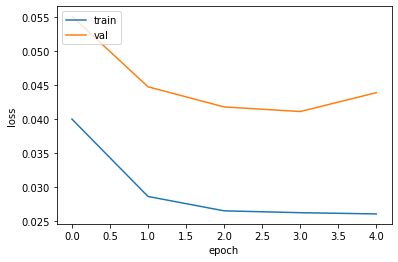

Calculating metrics
filename number 2 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.057228   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.045737   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.068490   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.046426   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.036773   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.045737  
2   0.403581   0.909091        1.0  0.068490  
3   0.414601   0.870130        1.0  0.046426  
4   0.414601   0.870130        1.0  0.036773  
5   0.362948   0.883117        1.0  0.033096  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 65us/step - loss: 0.0526 - rm

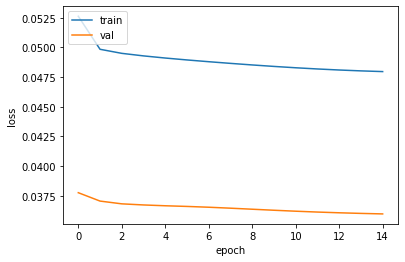

Calculating metrics
filename number 3 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.081356   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.056497   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.039171   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.044444   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.023352   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.056497  
2   0.403581   0.909091        1.0  0.039171  
3   0.414601   0.870130        1.0  0.044444  
4   0.414601   0.870130        1.0  0.023352  
5   0.362948   0.883117        1.0  0.044068  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0379 - rm

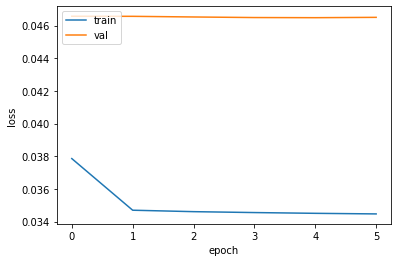

Calculating metrics
filename number 4 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.091274   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.090772   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.048144   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.023069   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.016550   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.090772  
2   0.403581   0.909091        1.0  0.048144  
3   0.414601   0.870130        1.0  0.023069  
4   0.414601   0.870130        1.0  0.016550  
5   0.362948   0.883117        1.0  0.017553  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 57us/step - loss: 0.0563 - rm

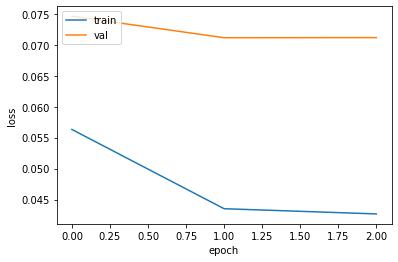

Calculating metrics
filename number 5 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.059770   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.065900   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.058238   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.134100   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.129502   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.065900  
2   0.403581   0.909091        1.0  0.058238  
3   0.414601   0.870130        1.0  0.134100  
4   0.414601   0.870130        1.0  0.129502  
5   0.362948   0.883117        1.0  0.032950  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 58us/step - loss: 0.0526 - rm

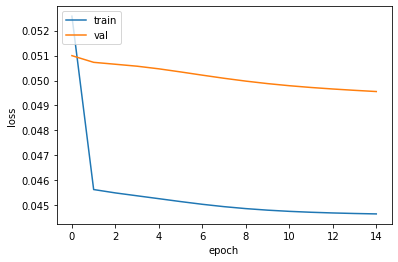

Calculating metrics
filename number 6 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.177316   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.164438   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.159485   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.120357   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.067360   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.164438  
2   0.403581   0.909091        1.0  0.159485  
3   0.414601   0.870130        1.0  0.120357  
4   0.414601   0.870130        1.0  0.067360  
5   0.362948   0.883117        1.0  0.018326  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 52us/step - loss: 0.0674 - rm

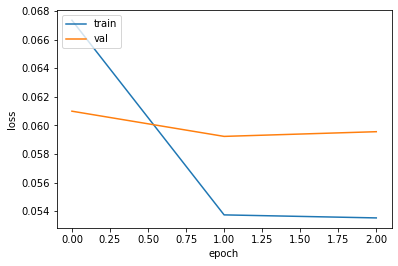

Calculating metrics
filename number 7 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.173390   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.192009   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.177657   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.182700   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.169123   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.192009  
2   0.403581   0.909091        1.0  0.177657  
3   0.414601   0.870130        1.0  0.182700  
4   0.414601   0.870130        1.0  0.169123  
5   0.362948   0.883117        1.0  0.132273  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 52us/step - loss: 0.0513 - rm

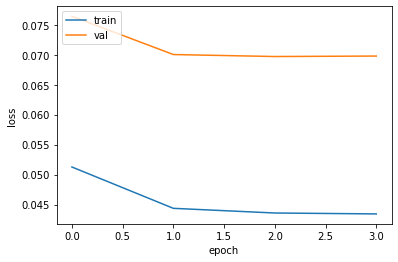

Calculating metrics
filename number 8 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.080729   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.038021   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.022917   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.029688   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.026563   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.038021  
2   0.403581   0.909091        1.0  0.022917  
3   0.414601   0.870130        1.0  0.029688  
4   0.414601   0.870130        1.0  0.026563  
5   0.362948   0.883117        1.0  0.010938  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 60us/step - loss: 0.0429 - rm

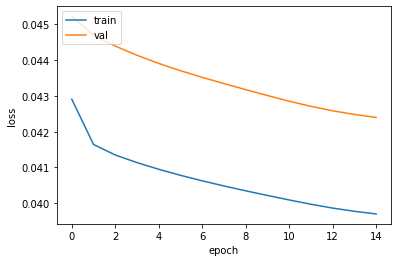

Calculating metrics
filename number 9 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064704   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.077584   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.065011   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.026372   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.010733   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.077584  
2   0.403581   0.909091        1.0  0.065011  
3   0.414601   0.870130        1.0  0.026372  
4   0.414601   0.870130        1.0  0.010733  
5   0.362948   0.883117        1.0  0.018399  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 54us/step - loss: 0.0495 - rm

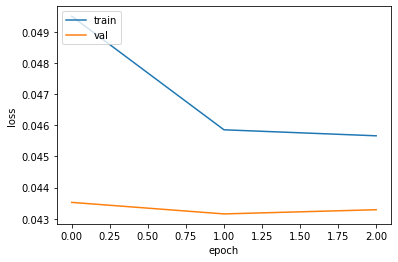

Calculating metrics
filename number 10 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.098323   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.056680   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.009254   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.006362   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.017351   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.056680  
2   0.403581   0.909091        1.0  0.009254  
3   0.414601   0.870130        1.0  0.006362  
4   0.414601   0.870130        1.0  0.017351  
5   0.362948   0.883117        1.0  0.000000  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 52us/step - loss: 0.0581 - r

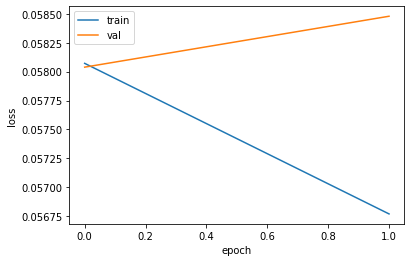

Calculating metrics
filename number 11 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.034779   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.042508   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.030056   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.048519   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.031773   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.042508  
2   0.403581   0.909091        1.0  0.030056  
3   0.414601   0.870130        1.0  0.048519  
4   0.414601   0.870130        1.0  0.031773  
5   0.362948   0.883117        1.0  0.034350  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 4s 139us/step - loss: 0.0542 - 

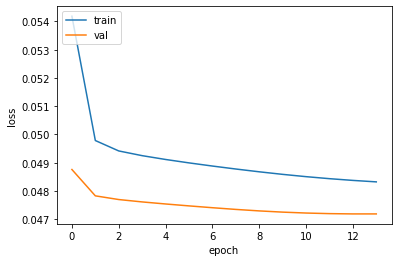

Calculating metrics
filename number 12 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.135900   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.129672   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.095696   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.093431   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.093431   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.129672  
2   0.403581   0.909091        1.0  0.095696  
3   0.414601   0.870130        1.0  0.093431  
4   0.414601   0.870130        1.0  0.093431  
5   0.362948   0.883117        1.0  0.062288  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 64us/step - loss: 0.0613 - r

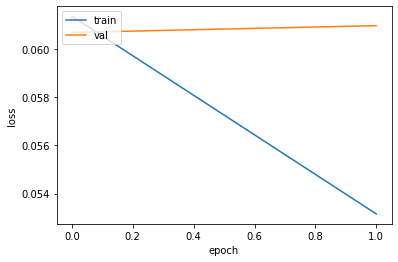

Calculating metrics
filename number 13 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.028707   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.022290   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.036136   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.022627   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.034110   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.022290  
2   0.403581   0.909091        1.0  0.036136  
3   0.414601   0.870130        1.0  0.022627  
4   0.414601   0.870130        1.0  0.034110  
5   0.362948   0.883117        1.0  0.024316  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 63us/step - loss: 0.0389 - r

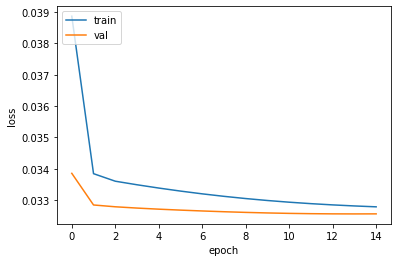

Calculating metrics
filename number 14 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.150743   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.148620   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.150743   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.148620   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.148620   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.148620  
2   0.403581   0.909091        1.0  0.150743  
3   0.414601   0.870130        1.0  0.148620  
4   0.414601   0.870130        1.0  0.148620  
5   0.362948   0.883117        1.0  0.148620  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 3s 85us/step - loss: 0.0672 - r

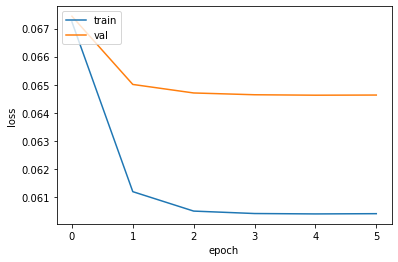

Calculating metrics
filename number 15 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.047085   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.017489   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.033184   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.009417   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.013453   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.017489  
2   0.403581   0.909091        1.0  0.033184  
3   0.414601   0.870130        1.0  0.009417  
4   0.414601   0.870130        1.0  0.013453  
5   0.362948   0.883117        1.0  0.014798  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 65us/step - loss: 0.0482 - r

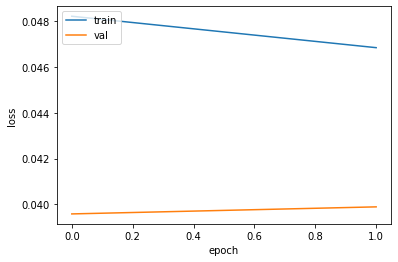

Calculating metrics
filename number 16 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008182   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.057273   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.050909   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.014545   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.004545   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.057273  
2   0.403581   0.909091        1.0  0.050909  
3   0.414601   0.870130        1.0  0.014545  
4   0.414601   0.870130        1.0  0.004545  
5   0.362948   0.883117        1.0  0.004545  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 58us/step - loss: 0.0406 - r

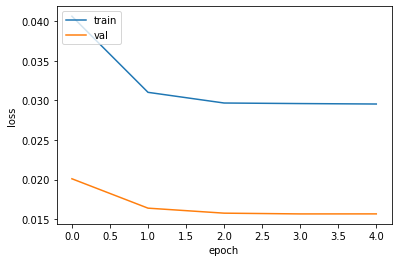

Calculating metrics
filename number 17 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.170660   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.205308   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.178032   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.105418   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.043494   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.205308  
2   0.403581   0.909091        1.0  0.178032  
3   0.414601   0.870130        1.0  0.105418  
4   0.414601   0.870130        1.0  0.043494  
5   0.362948   0.883117        1.0  0.034648  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 54us/step - loss: 0.0602 - r

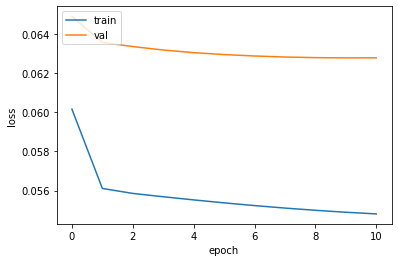

Calculating metrics
filename number 18 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.041575   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.042670   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.050328   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.051422   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.047046   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.042670  
2   0.403581   0.909091        1.0  0.050328  
3   0.414601   0.870130        1.0  0.051422  
4   0.414601   0.870130        1.0  0.047046  
5   0.362948   0.883117        1.0  0.042670  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 55us/step - loss: 0.0459 - r

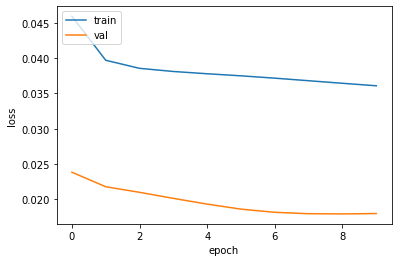

Calculating metrics
filename number 19 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.348600   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.348600   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.351145   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.353690   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.351145   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.348600  
2   0.403581   0.909091        1.0  0.351145  
3   0.414601   0.870130        1.0  0.353690  
4   0.414601   0.870130        1.0  0.351145  
5   0.362948   0.883117        1.0  0.353690  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 55us/step - loss: 0.0518 - r

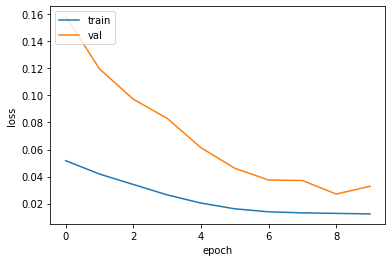

Calculating metrics
filename number 20 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.017737   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.020220   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.006740   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.010642   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.000709   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.020220  
2   0.403581   0.909091        1.0  0.006740  
3   0.414601   0.870130        1.0  0.010642  
4   0.414601   0.870130        1.0  0.000709  
5   0.362948   0.883117        1.0  0.009933  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 54us/step - loss: 0.0541 - r

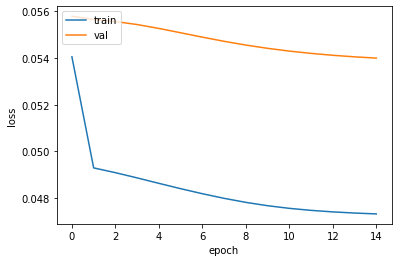

Calculating metrics
filename number 21 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.062662   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.059364   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.058186   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.056537   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.085041   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.059364  
2   0.403581   0.909091        1.0  0.058186  
3   0.414601   0.870130        1.0  0.056537  
4   0.414601   0.870130        1.0  0.085041  
5   0.362948   0.883117        1.0  0.055359  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 54us/step - loss: 0.0512 - r

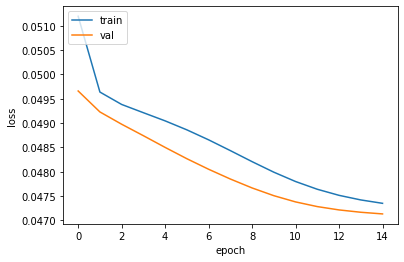

Calculating metrics
filename number 22 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.004786   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.004418   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.006996   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.023196   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.004786   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.004418  
2   0.403581   0.909091        1.0  0.006996  
3   0.414601   0.870130        1.0  0.023196  
4   0.414601   0.870130        1.0  0.004786  
5   0.362948   0.883117        1.0  0.004418  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 3s 85us/step - loss: 0.0399 - r

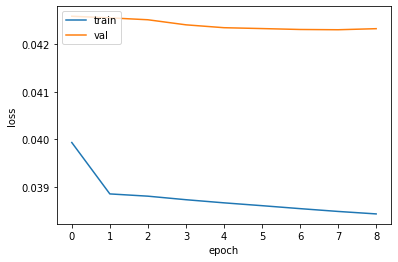

Calculating metrics
filename number 23 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.061490   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.062533   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.059406   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.055237   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.046378   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.062533  
2   0.403581   0.909091        1.0  0.059406  
3   0.414601   0.870130        1.0  0.055237  
4   0.414601   0.870130        1.0  0.046378  
5   0.362948   0.883117        1.0  0.031787  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 59us/step - loss: 0.0718 - r

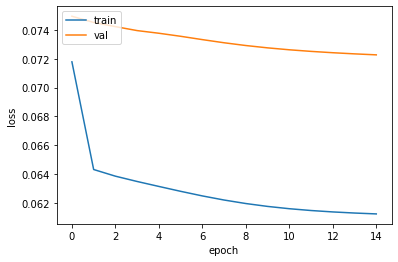

Calculating metrics
filename number 24 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.034693   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.031649   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.031041   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.057517   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.051430   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.031649  
2   0.403581   0.909091        1.0  0.031041  
3   0.414601   0.870130        1.0  0.057517  
4   0.414601   0.870130        1.0  0.051430  
5   0.362948   0.883117        1.0  0.039257  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 56us/step - loss: 0.0570 - r

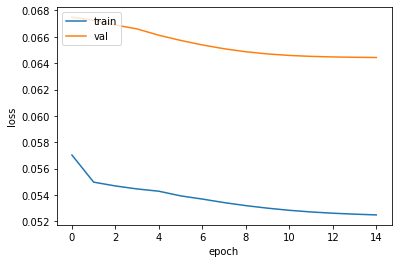

Calculating metrics
filename number 25 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.149047   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.174177   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.142981   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.163778   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.116984   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.174177  
2   0.403581   0.909091        1.0  0.142981  
3   0.414601   0.870130        1.0  0.163778  
4   0.414601   0.870130        1.0  0.116984  
5   0.362948   0.883117        1.0  0.136915  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 54us/step - loss: 0.0528 - r

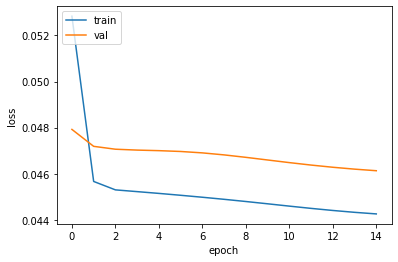

Calculating metrics
filename number 26 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.078140   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.050445   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.057369   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.025223   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.015826   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.050445  
2   0.403581   0.909091        1.0  0.057369  
3   0.414601   0.870130        1.0  0.025223  
4   0.414601   0.870130        1.0  0.015826  
5   0.362948   0.883117        1.0  0.018299  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 53us/step - loss: 0.0671 - r

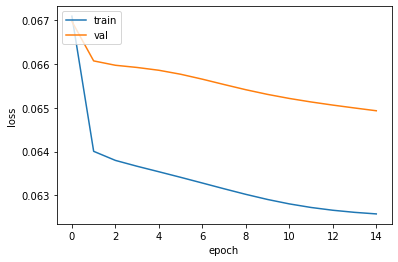

Calculating metrics
filename number 27 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.081736   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.058527   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.073663   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.076690   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.070636   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.058527  
2   0.403581   0.909091        1.0  0.073663  
3   0.414601   0.870130        1.0  0.076690  
4   0.414601   0.870130        1.0  0.070636  
5   0.362948   0.883117        1.0  0.042381  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 57us/step - loss: 0.0628 - r

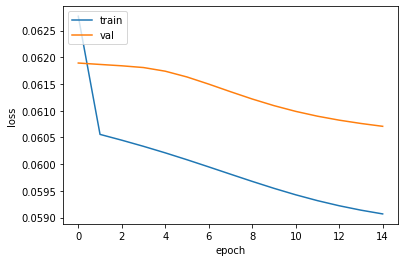

Calculating metrics
filename number 28 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.027004   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.026353   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.025919   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.027763   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.024075   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.026353  
2   0.403581   0.909091        1.0  0.025919  
3   0.414601   0.870130        1.0  0.027763  
4   0.414601   0.870130        1.0  0.024075  
5   0.362948   0.883117        1.0  0.013881  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 57us/step - loss: 0.0223 - r

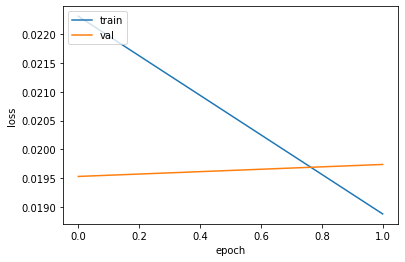

Calculating metrics
filename number 29 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064494   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.067961   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.039875   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.030166   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.039528   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.067961  
2   0.403581   0.909091        1.0  0.039875  
3   0.414601   0.870130        1.0  0.030166  
4   0.414601   0.870130        1.0  0.039528  
5   0.362948   0.883117        1.0  0.039528  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 55us/step - loss: 0.0669 - r

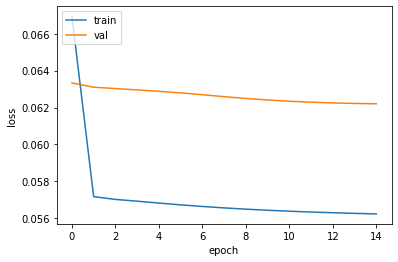

Calculating metrics
filename number 30 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.038927   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.064177   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.061547   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.087322   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.075224   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.064177  
2   0.403581   0.909091        1.0  0.061547  
3   0.414601   0.870130        1.0  0.087322  
4   0.414601   0.870130        1.0  0.075224  
5   0.362948   0.883117        1.0  0.013151  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 57us/step - loss: 0.0486 - r

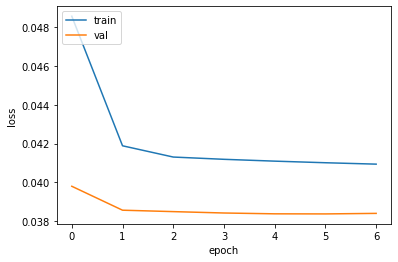

Calculating metrics
filename number 31 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.004092   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.003581   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.003581   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.003581   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.004092   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.003581  
2   0.403581   0.909091        1.0  0.003581  
3   0.414601   0.870130        1.0  0.003581  
4   0.414601   0.870130        1.0  0.004092  
5   0.362948   0.883117        1.0  0.003581  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 58us/step - loss: 0.0431 - r

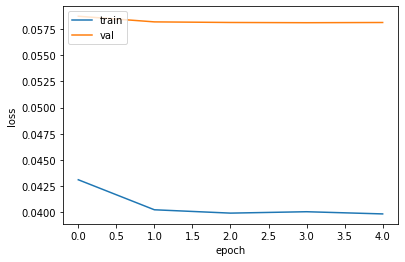

Calculating metrics
filename number 32 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.117247   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.204992   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.197428   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.126324   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.069592   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.204992  
2   0.403581   0.909091        1.0  0.197428  
3   0.414601   0.870130        1.0  0.126324  
4   0.414601   0.870130        1.0  0.069592  
5   0.362948   0.883117        1.0  0.077912  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 57us/step - loss: 0.0676 - r

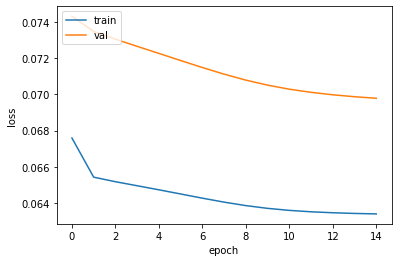

Calculating metrics
filename number 33 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.096743   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.078544   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.082375   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.089080   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.045019   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.078544  
2   0.403581   0.909091        1.0  0.082375  
3   0.414601   0.870130        1.0  0.089080  
4   0.414601   0.870130        1.0  0.045019  
5   0.362948   0.883117        1.0  0.027299  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 57us/step - loss: 0.0536 - r

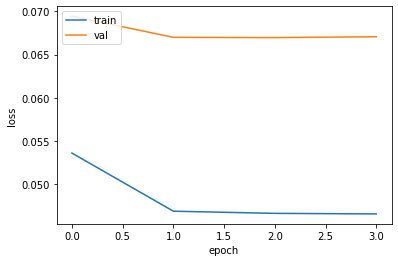

Calculating metrics
filename number 34 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.034228   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.034228   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.034899   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.034228   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.034899   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.034228  
2   0.403581   0.909091        1.0  0.034899  
3   0.414601   0.870130        1.0  0.034228  
4   0.414601   0.870130        1.0  0.034899  
5   0.362948   0.883117        1.0  0.034228  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 57us/step - loss: 0.0460 - r

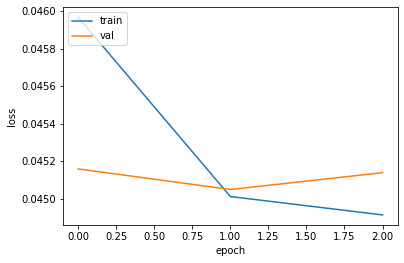

Calculating metrics
filename number 35 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.095645   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.084759   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.059487   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.068040   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.073484   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.084759  
2   0.403581   0.909091        1.0  0.059487  
3   0.414601   0.870130        1.0  0.068040  
4   0.414601   0.870130        1.0  0.073484  
5   0.362948   0.883117        1.0  0.027605  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 56us/step - loss: 0.0586 - r

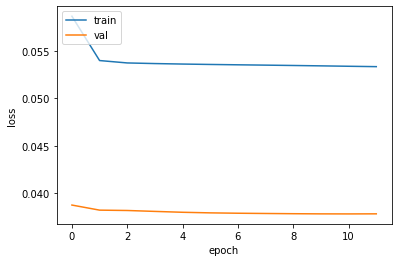

Calculating metrics
filename number 36 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064943   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.064297   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.030048   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.027141   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.005816   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.064297  
2   0.403581   0.909091        1.0  0.030048  
3   0.414601   0.870130        1.0  0.027141  
4   0.414601   0.870130        1.0  0.005816  
5   0.362948   0.883117        1.0  0.001616  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 57us/step - loss: 0.0433 - r

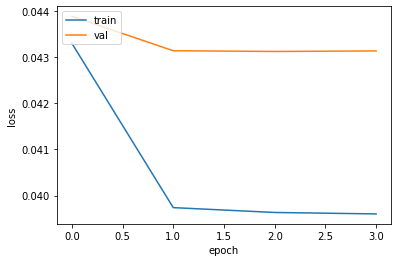

Calculating metrics
filename number 37 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.051475   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.050164   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.049508   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.031148   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.018689   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.050164  
2   0.403581   0.909091        1.0  0.049508  
3   0.414601   0.870130        1.0  0.031148  
4   0.414601   0.870130        1.0  0.018689  
5   0.362948   0.883117        1.0  0.010820  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 54us/step - loss: 0.0616 - r

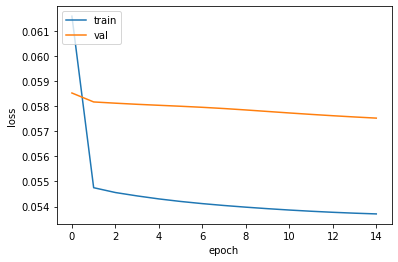

Calculating metrics
filename number 38 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.185067   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.210133   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.190933   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.202667   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.241600   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.210133  
2   0.403581   0.909091        1.0  0.190933  
3   0.414601   0.870130        1.0  0.202667  
4   0.414601   0.870130        1.0  0.241600  
5   0.362948   0.883117        1.0  0.317867  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 55us/step - loss: 0.0679 - r

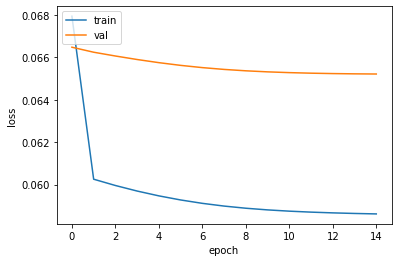

Calculating metrics
filename number 39 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.102847   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.093923   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.027624   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.014875   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.016150   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.093923  
2   0.403581   0.909091        1.0  0.027624  
3   0.414601   0.870130        1.0  0.014875  
4   0.414601   0.870130        1.0  0.016150  
5   0.362948   0.883117        1.0  0.015725  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 55us/step - loss: 0.0518 - r

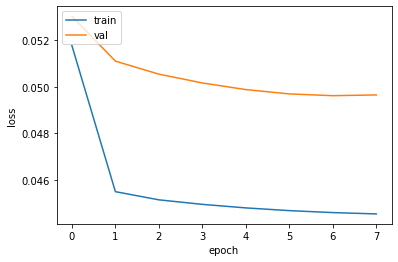

Calculating metrics
filename number 40 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.025506   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.033861   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.022867   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.020668   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.036060   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.033861  
2   0.403581   0.909091        1.0  0.022867  
3   0.414601   0.870130        1.0  0.020668  
4   0.414601   0.870130        1.0  0.036060  
5   0.362948   0.883117        1.0  0.030783  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 56us/step - loss: 0.0640 - r

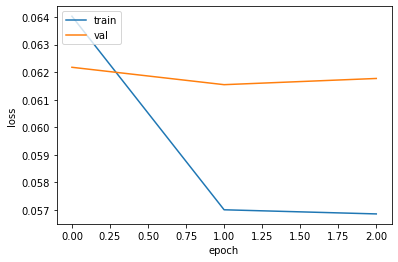

Calculating metrics
filename number 41 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0   0.803549   0.637883   0.466877   0.701607   0.478840   
2        0.0   0.803549   0.637883   0.466877   0.701607   0.478840   
3        0.0   0.797212   0.662953   0.479232   0.703282   0.475585   
4        0.0   0.797212   0.662953   0.479232   0.703282   0.475585   
5        0.0   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)  var1(t)  
1   0.403581   0.909091        1.0      0.0  
2   0.403581   0.909091        1.0      0.0  
3   0.414601   0.870130        1.0      0.0  
4   0.414601   0.870130        1.0      0.0  
5   0.362948   0.883117        1.0      0.0  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 55us/step - loss: 0.0048 - rmsle_l

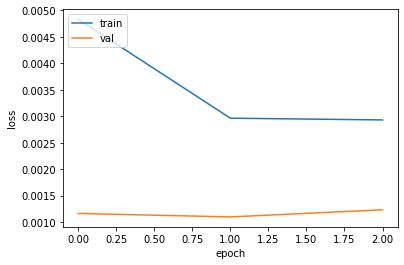

Calculating metrics
filename number 42 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.058342   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.148627   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.055702   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.064678   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.053590   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.148627  
2   0.403581   0.909091        1.0  0.055702  
3   0.414601   0.870130        1.0  0.064678  
4   0.414601   0.870130        1.0  0.053590  
5   0.362948   0.883117        1.0  0.045143  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 55us/step - loss: 0.0614 - r

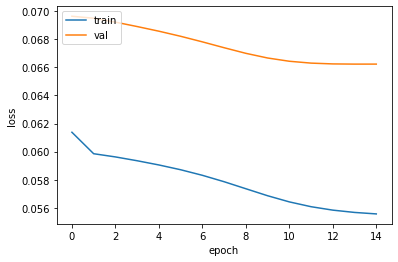

Calculating metrics
filename number 43 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.004248   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.010973   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.010265   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.003540   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.007080   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.010973  
2   0.403581   0.909091        1.0  0.010265  
3   0.414601   0.870130        1.0  0.003540  
4   0.414601   0.870130        1.0  0.007080  
5   0.362948   0.883117        1.0  0.010265  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 56us/step - loss: 0.0693 - r

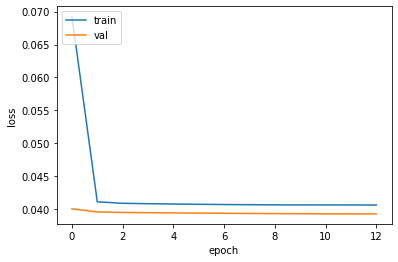

Calculating metrics
filename number 44 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.014610   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.021662   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.018640   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.014106   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.024685   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.021662  
2   0.403581   0.909091        1.0  0.018640  
3   0.414601   0.870130        1.0  0.014106  
4   0.414601   0.870130        1.0  0.024685  
5   0.362948   0.883117        1.0  0.013602  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 54us/step - loss: 0.0477 - r

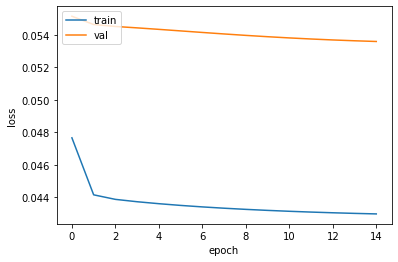

Calculating metrics
filename number 45 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.065014   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.060966   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.058184   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.058690   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.056160   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.060966  
2   0.403581   0.909091        1.0  0.058184  
3   0.414601   0.870130        1.0  0.058690  
4   0.414601   0.870130        1.0  0.056160  
5   0.362948   0.883117        1.0  0.045535  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 55us/step - loss: 0.0614 - r

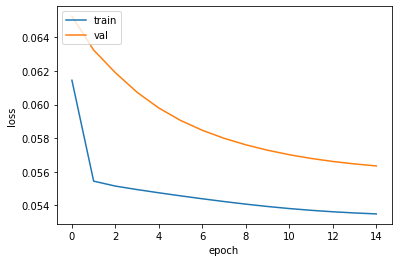

Calculating metrics
filename number 46 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.106068   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.089750   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.058134   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.083631   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.105558   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.089750  
2   0.403581   0.909091        1.0  0.058134  
3   0.414601   0.870130        1.0  0.083631  
4   0.414601   0.870130        1.0  0.105558  
5   0.362948   0.883117        1.0  0.080061  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 65us/step - loss: 0.0492 - r

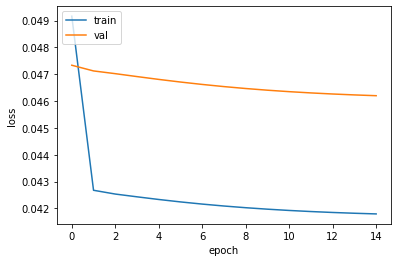

Calculating metrics
filename number 47 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.027547   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.027879   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.024892   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.024892   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.041155   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.027879  
2   0.403581   0.909091        1.0  0.024892  
3   0.414601   0.870130        1.0  0.024892  
4   0.414601   0.870130        1.0  0.041155  
5   0.362948   0.883117        1.0  0.022237  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 3s 98us/step - loss: 0.0418 - r

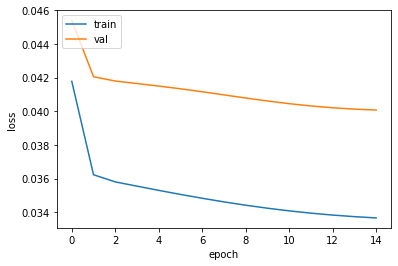

Calculating metrics
filename number 48 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.054991   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.057382   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.036461   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.037059   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.054393   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.057382  
2   0.403581   0.909091        1.0  0.036461  
3   0.414601   0.870130        1.0  0.037059  
4   0.414601   0.870130        1.0  0.054393  
5   0.362948   0.883117        1.0  0.065750  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 59us/step - loss: 0.0622 - r

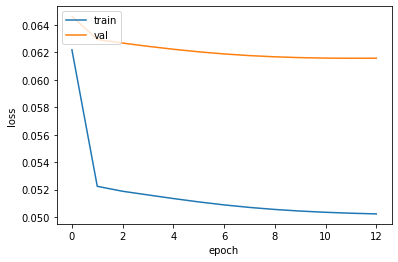

Calculating metrics
filename number 49 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.115551   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.117959   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.039961   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.030332   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.028888   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.117959  
2   0.403581   0.909091        1.0  0.039961  
3   0.414601   0.870130        1.0  0.030332  
4   0.414601   0.870130        1.0  0.028888  
5   0.362948   0.883117        1.0  0.014925  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 4s 135us/step - loss: 0.0661 - 

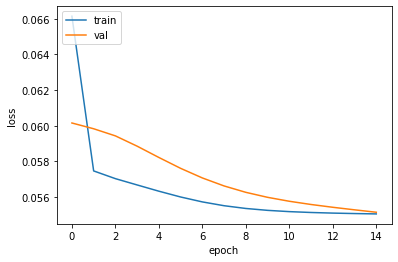

Calculating metrics
filename number 50 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.015800   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.015992   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.026204   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.024855   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.015029   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.015992  
2   0.403581   0.909091        1.0  0.026204  
3   0.414601   0.870130        1.0  0.024855  
4   0.414601   0.870130        1.0  0.015029  
5   0.362948   0.883117        1.0  0.016378  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 51us/step - loss: 0.0499 - r

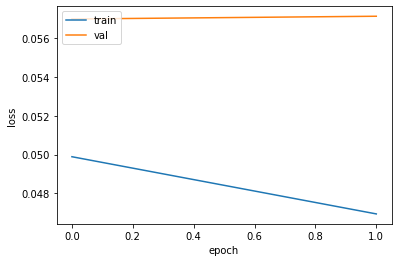

Calculating metrics
filename number 51 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.002538   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.124365   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.002538   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.035533   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.139594   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.124365  
2   0.403581   0.909091        1.0  0.002538  
3   0.414601   0.870130        1.0  0.035533  
4   0.414601   0.870130        1.0  0.139594  
5   0.362948   0.883117        1.0  0.015228  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 49us/step - loss: 0.0802 - r

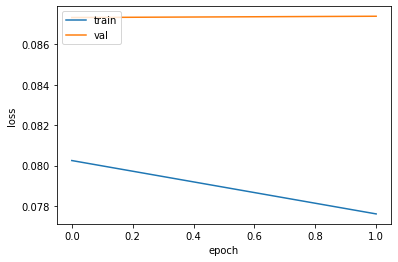

Calculating metrics
filename number 52 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.192661   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.181193   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.190367   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.173165   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.178899   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.181193  
2   0.403581   0.909091        1.0  0.190367  
3   0.414601   0.870130        1.0  0.173165  
4   0.414601   0.870130        1.0  0.178899  
5   0.362948   0.883117        1.0  0.159977  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 56us/step - loss: 0.0411 - r

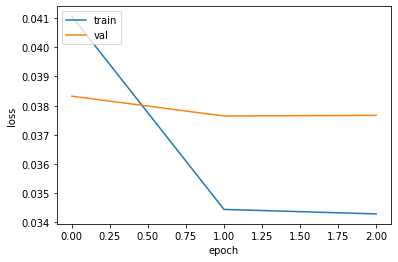

Calculating metrics
filename number 53 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.012099   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.006839   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.015781   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.003682   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.018937   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.006839  
2   0.403581   0.909091        1.0  0.015781  
3   0.414601   0.870130        1.0  0.003682  
4   0.414601   0.870130        1.0  0.018937  
5   0.362948   0.883117        1.0  0.002630  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 58us/step - loss: 0.0401 - r

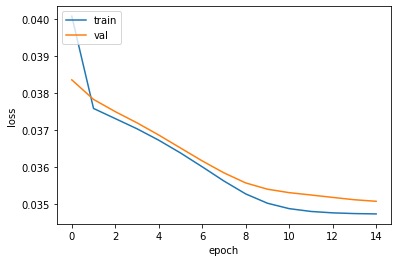

Calculating metrics
filename number 54 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.105263   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.058704   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.053846   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.136437   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.060729   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.058704  
2   0.403581   0.909091        1.0  0.053846  
3   0.414601   0.870130        1.0  0.136437  
4   0.414601   0.870130        1.0  0.060729  
5   0.362948   0.883117        1.0  0.124291  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 48us/step - loss: 0.0402 - r

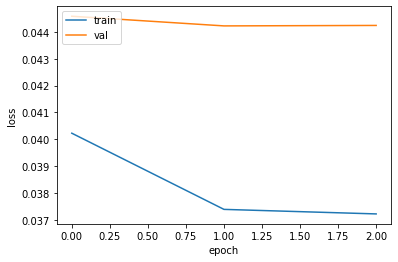

Calculating metrics
filename number 55 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.011862   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.004126   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.010315   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.011346   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.006189   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.004126  
2   0.403581   0.909091        1.0  0.010315  
3   0.414601   0.870130        1.0  0.011346  
4   0.414601   0.870130        1.0  0.006189  
5   0.362948   0.883117        1.0  0.008252  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 3s 100us/step - loss: 0.0613 - 

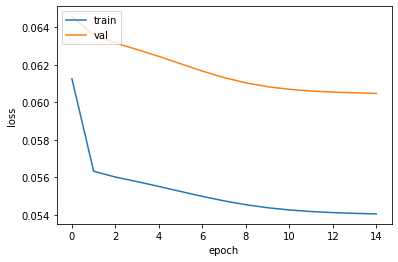

Calculating metrics
filename number 56 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.068792   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.121644   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.171980   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.135906   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.065436   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.121644  
2   0.403581   0.909091        1.0  0.171980  
3   0.414601   0.870130        1.0  0.135906  
4   0.414601   0.870130        1.0  0.065436  
5   0.362948   0.883117        1.0  0.040268  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 75us/step - loss: 0.0665 - r

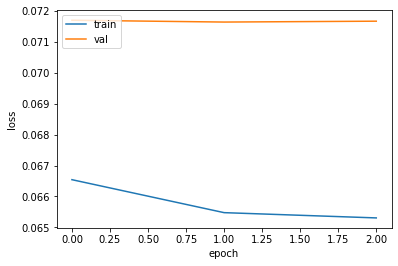

Calculating metrics
filename number 57 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.062462   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.062462   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.056398   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.068526   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.071559   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.062462  
2   0.403581   0.909091        1.0  0.056398  
3   0.414601   0.870130        1.0  0.068526  
4   0.414601   0.870130        1.0  0.071559  
5   0.362948   0.883117        1.0  0.067920  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 56us/step - loss: 0.0478 - r

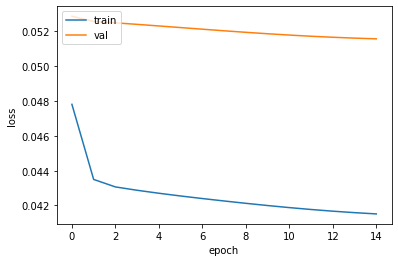

Calculating metrics
filename number 58 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.374855   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.117613   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.073001   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.067207   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.035921   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.117613  
2   0.403581   0.909091        1.0  0.073001  
3   0.414601   0.870130        1.0  0.067207  
4   0.414601   0.870130        1.0  0.035921  
5   0.362948   0.883117        1.0  0.021437  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 48us/step - loss: 0.0617 - r

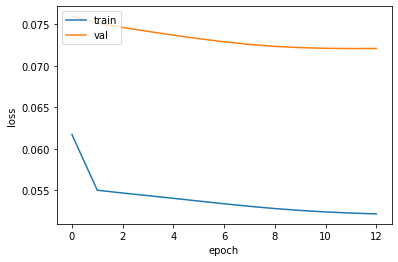

Calculating metrics
filename number 59 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.071965   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.090738   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.186483   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.028786   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.044431   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.090738  
2   0.403581   0.909091        1.0  0.186483  
3   0.414601   0.870130        1.0  0.028786  
4   0.414601   0.870130        1.0  0.044431  
5   0.362948   0.883117        1.0  0.028160  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 47us/step - loss: 0.0501 - r

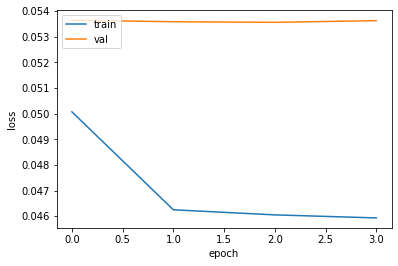

Calculating metrics
filename number 60 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.045230   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.063958   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.060071   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.045936   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.055124   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.063958  
2   0.403581   0.909091        1.0  0.060071  
3   0.414601   0.870130        1.0  0.045936  
4   0.414601   0.870130        1.0  0.055124  
5   0.362948   0.883117        1.0  0.067491  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 47us/step - loss: 0.0453 - r

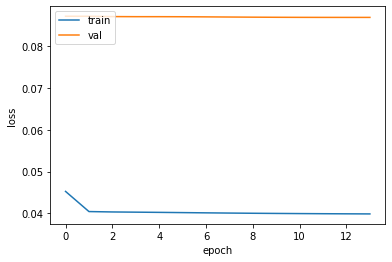

Calculating metrics
filename number 61 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.142468   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.049002   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.007260   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.007260   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.013612   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.049002  
2   0.403581   0.909091        1.0  0.007260  
3   0.414601   0.870130        1.0  0.007260  
4   0.414601   0.870130        1.0  0.013612  
5   0.362948   0.883117        1.0  0.034483  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 47us/step - loss: 0.0386 - r

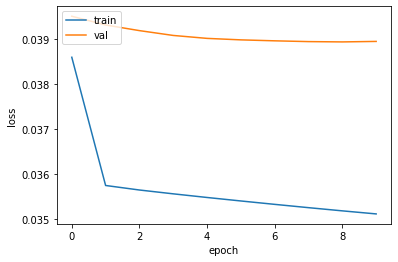

Calculating metrics
filename number 62 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.114137   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.385646   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.102897   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.087765   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.073498   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.385646  
2   0.403581   0.909091        1.0  0.102897  
3   0.414601   0.870130        1.0  0.087765  
4   0.414601   0.870130        1.0  0.073498  
5   0.362948   0.883117        1.0  0.006485  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 47us/step - loss: 0.0583 - r

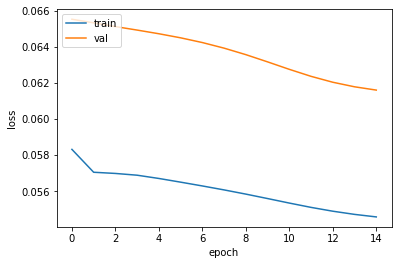

Calculating metrics
filename number 63 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.029336   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.029336   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.020276   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.018550   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.030198   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.029336  
2   0.403581   0.909091        1.0  0.020276  
3   0.414601   0.870130        1.0  0.018550  
4   0.414601   0.870130        1.0  0.030198  
5   0.362948   0.883117        1.0  0.029336  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 47us/step - loss: 0.0461 - r

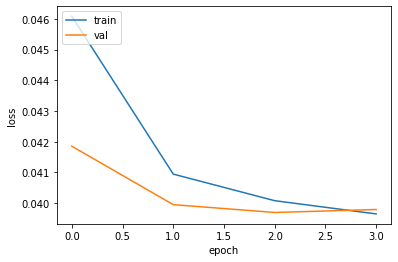

Calculating metrics
filename number 64 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.015883   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.027586   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.036782   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.050157   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.020481   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.027586  
2   0.403581   0.909091        1.0  0.036782  
3   0.414601   0.870130        1.0  0.050157  
4   0.414601   0.870130        1.0  0.020481  
5   0.362948   0.883117        1.0  0.018600  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 56us/step - loss: 0.0566 - r

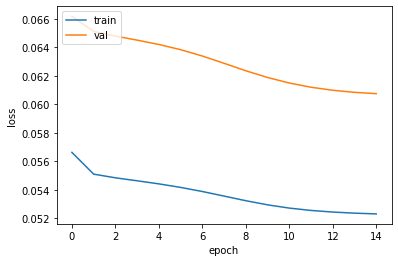

Calculating metrics
filename number 65 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.062927   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.054720   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.095759   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.069767   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.125855   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.054720  
2   0.403581   0.909091        1.0  0.095759  
3   0.414601   0.870130        1.0  0.069767  
4   0.414601   0.870130        1.0  0.125855  
5   0.362948   0.883117        1.0  0.050616  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0472 - r

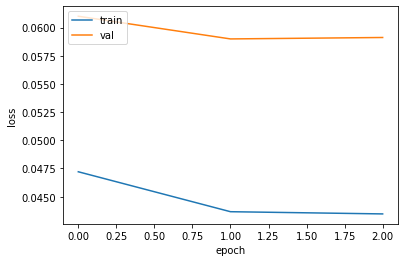

Calculating metrics
filename number 66 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.191874   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.067720   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.046652   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.056433   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.053424   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.067720  
2   0.403581   0.909091        1.0  0.046652  
3   0.414601   0.870130        1.0  0.056433  
4   0.414601   0.870130        1.0  0.053424  
5   0.362948   0.883117        1.0  0.037622  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0861 - r

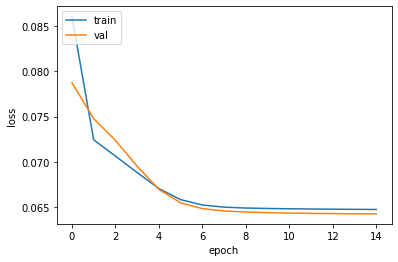

Calculating metrics
filename number 67 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.086435   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.146859   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.088435   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.083233   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.036014   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.146859  
2   0.403581   0.909091        1.0  0.088435  
3   0.414601   0.870130        1.0  0.083233  
4   0.414601   0.870130        1.0  0.036014  
5   0.362948   0.883117        1.0  0.028812  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0620 - r

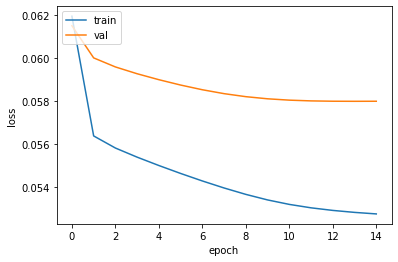

Calculating metrics
filename number 68 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.065990   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.103509   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.094902   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.068197   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.030678   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.103509  
2   0.403581   0.909091        1.0  0.094902  
3   0.414601   0.870130        1.0  0.068197  
4   0.414601   0.870130        1.0  0.030678  
5   0.362948   0.883117        1.0  0.018098  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0475 - r

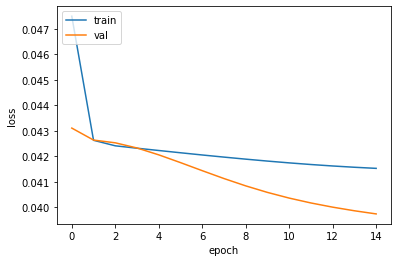

Calculating metrics
filename number 69 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.001821   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.001821   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.019572   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.009103   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.001821   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.001821  
2   0.403581   0.909091        1.0  0.019572  
3   0.414601   0.870130        1.0  0.009103  
4   0.414601   0.870130        1.0  0.001821  
5   0.362948   0.883117        1.0  0.001365  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0221 - r

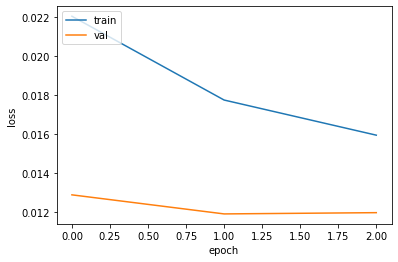

Calculating metrics
filename number 70 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.036753   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.033691   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.035222   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.093415   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.041348   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.033691  
2   0.403581   0.909091        1.0  0.035222  
3   0.414601   0.870130        1.0  0.093415  
4   0.414601   0.870130        1.0  0.041348  
5   0.362948   0.883117        1.0  0.038285  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 47us/step - loss: 0.0584 - r

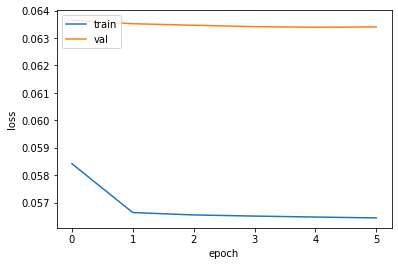

Calculating metrics
filename number 71 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129697   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.111111   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.110303   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.102626   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.076768   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.111111  
2   0.403581   0.909091        1.0  0.110303  
3   0.414601   0.870130        1.0  0.102626  
4   0.414601   0.870130        1.0  0.076768  
5   0.362948   0.883117        1.0  0.036768  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0767 - r

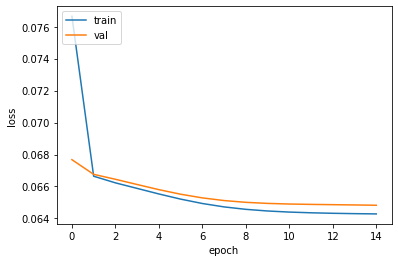

Calculating metrics
filename number 72 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.002915   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.005831   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.002915   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.064140   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.221574   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.005831  
2   0.403581   0.909091        1.0  0.002915  
3   0.414601   0.870130        1.0  0.064140  
4   0.414601   0.870130        1.0  0.221574  
5   0.362948   0.883117        1.0  0.090379  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 54us/step - loss: 0.1031 - r

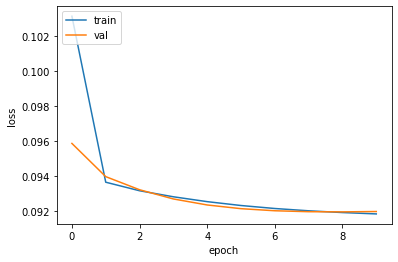

Calculating metrics
filename number 73 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.080287   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.077419   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.088172   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.074910   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.083154   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.077419  
2   0.403581   0.909091        1.0  0.088172  
3   0.414601   0.870130        1.0  0.074910  
4   0.414601   0.870130        1.0  0.083154  
5   0.362948   0.883117        1.0  0.072401  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 54us/step - loss: 0.0561 - r

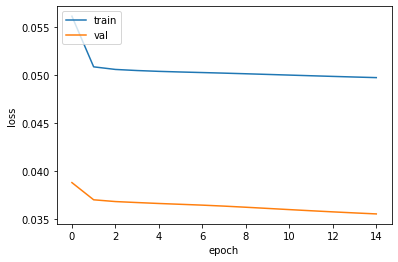

Calculating metrics
filename number 74 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008497   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.007668   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.009948   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.009534   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.010777   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.007668  
2   0.403581   0.909091        1.0  0.009948  
3   0.414601   0.870130        1.0  0.009534  
4   0.414601   0.870130        1.0  0.010777  
5   0.362948   0.883117        1.0  0.008083  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 48us/step - loss: 0.0583 - r

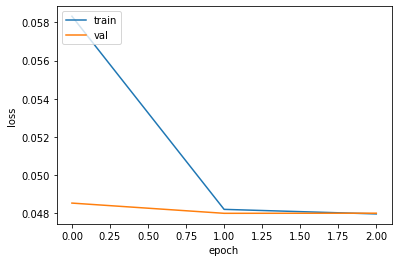

Calculating metrics
filename number 75 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.098375   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.087682   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.082549   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.064585   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.059880   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.087682  
2   0.403581   0.909091        1.0  0.082549  
3   0.414601   0.870130        1.0  0.064585  
4   0.414601   0.870130        1.0  0.059880  
5   0.362948   0.883117        1.0  0.079555  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0379 - r

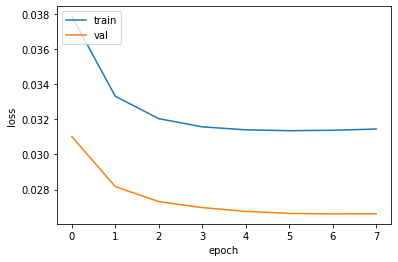

Calculating metrics
filename number 76 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008691   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.008691   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.037832   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.015337   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.008691   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.008691  
2   0.403581   0.909091        1.0  0.037832  
3   0.414601   0.870130        1.0  0.015337  
4   0.414601   0.870130        1.0  0.008691  
5   0.362948   0.883117        1.0  0.031697  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 48us/step - loss: 0.0680 - r

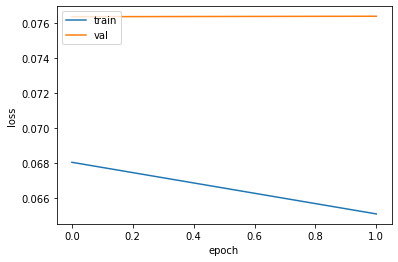

Calculating metrics
filename number 77 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.008759   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.016058   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.016058   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.003406   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.014599   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.016058  
2   0.403581   0.909091        1.0  0.016058  
3   0.414601   0.870130        1.0  0.003406  
4   0.414601   0.870130        1.0  0.014599  
5   0.362948   0.883117        1.0  0.019465  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 45us/step - loss: 0.0500 - r

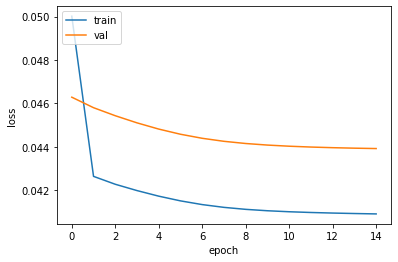

Calculating metrics
filename number 78 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.022879   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.026692   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.038608   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.031935   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.020972   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.026692  
2   0.403581   0.909091        1.0  0.038608  
3   0.414601   0.870130        1.0  0.031935  
4   0.414601   0.870130        1.0  0.020972  
5   0.362948   0.883117        1.0  0.030505  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0659 - r

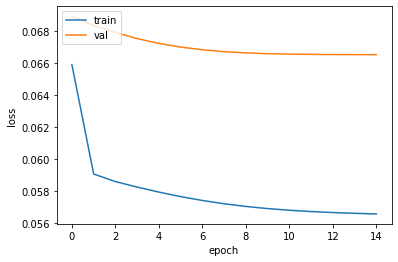

Calculating metrics
filename number 79 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.084674   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.298335   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.496754   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.476150   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.426757   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.298335  
2   0.403581   0.909091        1.0  0.496754  
3   0.414601   0.870130        1.0  0.476150  
4   0.414601   0.870130        1.0  0.426757  
5   0.362948   0.883117        1.0  0.042901  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0915 - r

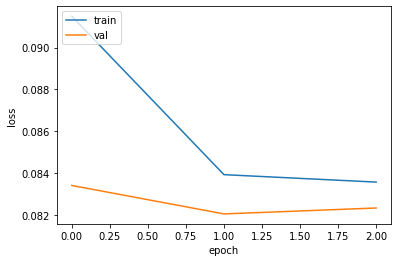

Calculating metrics
filename number 80 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.017019   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.017606   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.016432   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.023474   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.011737   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.017606  
2   0.403581   0.909091        1.0  0.016432  
3   0.414601   0.870130        1.0  0.023474  
4   0.414601   0.870130        1.0  0.011737  
5   0.362948   0.883117        1.0  0.021714  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 45us/step - loss: 0.0524 - r

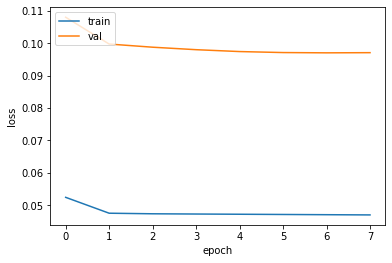

Calculating metrics
filename number 81 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.025629   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.020137   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.025629   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.023799   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.020137   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.020137  
2   0.403581   0.909091        1.0  0.025629  
3   0.414601   0.870130        1.0  0.023799  
4   0.414601   0.870130        1.0  0.020137  
5   0.362948   0.883117        1.0  0.026545  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 44us/step - loss: 0.0447 - r

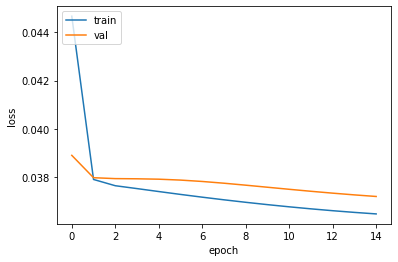

Calculating metrics
filename number 82 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.077701   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.097392   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.060138   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.060138   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.068654   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.097392  
2   0.403581   0.909091        1.0  0.060138  
3   0.414601   0.870130        1.0  0.060138  
4   0.414601   0.870130        1.0  0.068654  
5   0.362948   0.883117        1.0  0.113890  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 1s 46us/step - loss: 0.0301 - r

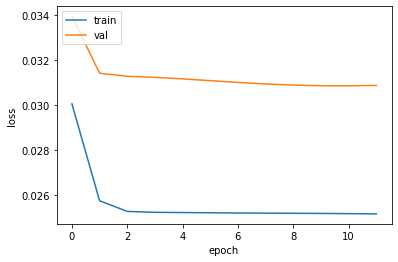

Calculating metrics
filename number 83 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.045735   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.013597   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.031520   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.016687   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.027194   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.013597  
2   0.403581   0.909091        1.0  0.031520  
3   0.414601   0.870130        1.0  0.016687  
4   0.414601   0.870130        1.0  0.027194  
5   0.362948   0.883117        1.0  0.028430  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 51us/step - loss: 0.0404 - r

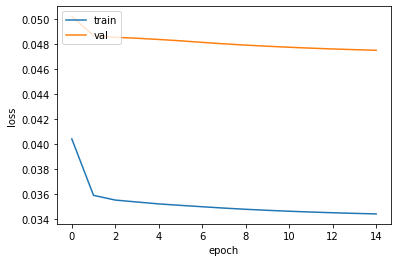

Calculating metrics
filename number 84 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.136885   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.068852   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.076230   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.070492   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.064754   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.068852  
2   0.403581   0.909091        1.0  0.076230  
3   0.414601   0.870130        1.0  0.070492  
4   0.414601   0.870130        1.0  0.064754  
5   0.362948   0.883117        1.0  0.034426  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 52us/step - loss: 0.0482 - r

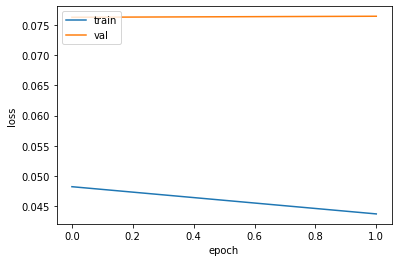

Calculating metrics
filename number 85 of 85
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.064265   0.803549   0.637883   0.466877   0.701607   0.478840   
2   0.055331   0.803549   0.637883   0.466877   0.701607   0.478840   
3   0.070317   0.797212   0.662953   0.479232   0.703282   0.475585   
4   0.047262   0.797212   0.662953   0.479232   0.703282   0.475585   
5   0.016138   0.711660   0.637883   0.475552   0.703952   0.476621   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.403581   0.909091        1.0  0.055331  
2   0.403581   0.909091        1.0  0.070317  
3   0.414601   0.870130        1.0  0.047262  
4   0.414601   0.870130        1.0  0.016138  
5   0.362948   0.883117        1.0  0.014697  
Splitting into train and test
(33600, 1, 9) (33600,) (1455, 1, 9) (1455,)
Designing network
Fitting network
Train on 32256 samples, validate on 1344 samples
Epoch 1/15
32256/32256 [==============================] - 2s 52us/step - loss: 0.0514 - r

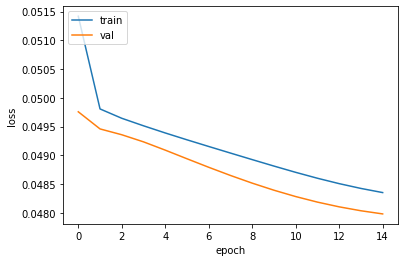

Calculating metrics


In [22]:
# load the dataset
path = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/code_datasets/1_data_frames/multivariate/comfortable_std"
all_files = glob.glob(path + "/*.csv")

i = 0
rmsle_t = []
rmse_t = []
for filename in all_files:
    i = i + 1
    print('filename number ' + str(i) + ' of ' + str(len(all_files)))
    df = pd.read_csv(filename,parse_dates = ['tstp'], index_col = ['tstp'])
    rmsle_i,rmse_i = lstm_multivariate(df)
    rmse_t.append(round(rmse_i,3))
    rmsle_t.append(round(rmsle_i,3))

In [21]:
print('RMSLE')
print('Min')
print(min(rmsle_t))
print('Avg')
print(np.average(rmsle_t))
print('Max')
print(max(rmsle_t))

print('RMSE')
print('Min')
print(min(rmse_t))
print('Avg')
print(np.average(rmse_t))
print('Max')
print(max(rmse_t))

RMSLE
Min
0.048
Avg
0.09785714285714284
Max
0.158
RMSE
Min
0.061
Avg
0.145
Max
0.253


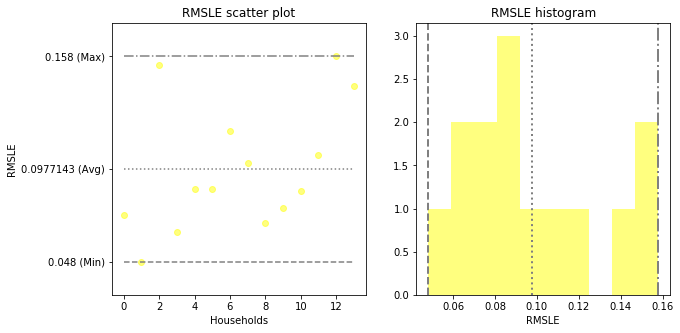

In [22]:
plt.figure(figsize = (10,5))
plt.subplot(121)
plt.scatter(range(len(rmsle_t)),rmsle_t,color = 'yellow',alpha = 0.5)
plt.plot(range(len(rmsle_t)),[min(rmsle_t)]*len(rmsle_t),color = 'grey',linestyle = '--')
plt.plot(range(len(rmsle_t)),[round(np.average(rmsle_t),7)]*len(rmsle_t),color = 'grey',linestyle = ':')
plt.plot(range(len(rmsle_t)),[max(rmsle_t)]*len(rmsle_t),color = 'grey',linestyle = '-.')
plt.yticks([min(rmsle_t),round(np.average(rmsle_t),7),max(rmsle_t)],[str(min(rmsle_t)) + ' (Min)',
                                                            str(round(np.average(rmsle_t),7)) + ' (Avg)',
                                                                         str(max(rmsle_t))+' (Max)'])
plt.title('RMSLE scatter plot',fontsize = 12)
plt.xlabel('Households')
plt.ylabel('RMSLE')

plt.subplot(122)
plt.hist(rmsle_t,color = 'yellow',alpha = 0.5)
plt.axvline(x=min(rmsle_t), color='grey', linestyle='--', linewidth=2)
plt.axvline(x=round(np.average(rmsle_t),7), color='grey', linestyle=':', linewidth=2)
plt.axvline(x=max(rmsle_t), color='grey', linestyle='-.', linewidth=2)

plt.title("RMSLE histogram",fontsize = 12)
plt.xlabel('RMSLE')
plt.savefig('/Users/mariabelenalberti/Desktop/multi_results/50_com_tou')

plt.show();

In [143]:
print(rmsle_t)

[0.077]
